In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import sampler
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import trange
import copy

In [2]:
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# Flickr8k Dataset

In [3]:
total_num_images = int(len(os.listdir('./Images')))
train_indices = (0, int(0.75 * total_num_images))
val_indices = (int(0.75 * total_num_images), int(0.9 * total_num_images))
test_indices =  (int(0.9 * total_num_images), total_num_images)
train_indices, val_indices, test_indices

((0, 6068), (6068, 7281), (7281, 8091))

### Determine Mean and Standard Deviation of L-channel

In [4]:
class Dummy_Flickr8k(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_locations = sorted(os.listdir(data_dir))
        
    def __len__(self):
        return len(self.image_locations)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_locations[idx])
        
        bgr_image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)
        resize_pil_image = T.functional.resize(pil_image, (224, 224))
        resized_rgb_image = np.array(resize_pil_image)
        resized_luv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2Luv)
        
        tensor_luv = T.functional.to_tensor(resized_luv_image) 
        return tensor_luv[0]

In [5]:
dummy_flick8k_dataset = Dummy_Flickr8k('./Images')
dummy_flick8k_loader = DataLoader(dummy_flick8k_dataset, batch_size=16)

# code taken from https://pytorch.org/docs/stable/torchvision/models.html
means = []
stds = []
for imgs in dummy_flick8k_loader:
    means.append(torch.mean(imgs))
    stds.append(torch.std(imgs))

mean_lchannel = torch.mean(torch.tensor(means))
std_lchannel = torch.mean(torch.tensor(stds))
mean_lchannel, std_lchannel

(tensor(0.4697), tensor(0.2610))

### Actual Training, Validation, and Testing Dataset with Normalization 

In [6]:
class Flickr8k(Dataset):
    def __init__(self, data_dir, index_range):
        self.data_dir = data_dir
        self.image_locations = sorted(os.listdir(data_dir))[index_range[0]:index_range[1]]
        
    def __len__(self):
        return len(self.image_locations)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_locations[idx])
        
        bgr_image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)
        resize_pil_image = T.functional.resize(pil_image, (224, 224))
        resized_rgb_image = np.array(resize_pil_image)
        resized_luv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2Luv)
        
        tensor_luv = T.functional.to_tensor(resized_luv_image) 
        l_stack = torch.stack((tensor_luv[0], tensor_luv[0], tensor_luv[0]), dim=0)
        normalized_l_stack = T.functional.normalize(
                                l_stack, 
                                mean=[0.4697] * 3, 
                                std=[0.2610] * 3
                             )
        return normalized_l_stack, tensor_luv[1:], tensor_luv[0]

# Model Architecture

In [7]:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        pretrained_vgg16 = models.vgg16_bn(pretrained=True, progress=True)
        
        self.first = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6)])
        self.second = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6,13)])
        self.third = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(13,23)])
        self.fourth = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(23,33)])
                
        self.fifth = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1), nn.BatchNorm2d(256), nn.ReLU())
        self.sixth = nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.seventh = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.eighth = nn.Sequential(nn.Conv2d(64, 2, kernel_size=3, padding=1), nn.Sigmoid())
        
        self.transpose1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.transpose2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.transpose3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        out1 = self.first(x)
        out2 = self.second(out1)
        out3 = self.third(out2)
        out4 = self.fourth(out3)
                
        out5 = self.fifth(out4)
        out6 = self.sixth(self.transpose1(out5) + out3)
        out7 = self.seventh(self.transpose2(out6) + out2)
        out8 = self.eighth(self.transpose3(out7) + out1)
    
        return out8

# Training

In [8]:
flick8k_train = Flickr8k('./Images', train_indices)
loader_train = DataLoader(flick8k_train, batch_size=32, shuffle=True)

flick8k_val = Flickr8k('./Images', val_indices)
loader_val = DataLoader(flick8k_val, batch_size=32)

flick8k_test = Flickr8k('./Images', test_indices)
loader_test = DataLoader(flick8k_test, batch_size=32)

In [9]:
def check_loss(split_name, model, loss_func, current_best):
    loader = None
    if split_name == 'val':
        loader = loader_val
    elif split_name == 'test':
        loader = loader_test
    else:
        raise NotImplementedError

    losses = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)
            losses.append(loss_func(scores, y).item())
    
    mean_loss = np.mean(losses)
    
    if split_name == 'test':
        return mean_loss
    
    if mean_loss < current_best["loss"]:
        current_best["loss"] = mean_loss
        current_best["model"] = copy.deepcopy(model)
        
    return mean_loss, current_best
        
def train(model, optimizer, scheduler, loss_func, epochs=1):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses = []
    val_losses = []
    
    current_best = {
        "loss": float('inf'),
        "model": model
    } 
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in trange(epochs):
        epoch_loss = []
        for t, (x, y, _) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            scores = model(x)
            loss = loss_func(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            epoch_loss.append(loss.item())

        val_loss, current_best = check_loss('val', model, loss_func, current_best)
        
        train_losses.append(np.mean(epoch_loss))
        val_losses.append(val_loss)
        print(f'Epoch {e}, train loss = {train_losses[-1]:.6f}, val loss = {val_losses[-1]:.6f}')
        scheduler.step(val_losses[-1])
        
    return train_losses, val_losses, current_best

In [10]:
def test_on_random_images(split_name, model):
    indices = None
    original_dataset = None
    if split_name == 'train': 
        print('Testing on Training Images...')
        indices = train_indices
        original_dataset = flick8k_train
    elif split_name == 'val':
        print('Testing on Validation Images...')
        indices = (0, val_indices[1] - val_indices[0])
        original_dataset = flick8k_val
    elif split_name == 'test':
        print('Testing on Test Images...')
        indices = (0, test_indices[1] - test_indices[0])
        original_dataset = flick8k_test
    else:
        raise NotImplementedError
        
    subset_indices = np.random.randint(*indices, 3)
    subset = Subset(original_dataset, subset_indices)
    loader_subset = DataLoader(subset, batch_size=1, shuffle=False)

    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    
    model = model.to(device='cpu')
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i, (normalized_input, uv_channel, l_channel) in enumerate(loader_subset):
            reformed_image = torch.stack((l_channel[0], uv_channel[0][0], uv_channel[0][1]), dim=0)
            reformed_pil_image = T.functional.to_pil_image(reformed_image)
            truth_luv = np.array(reformed_pil_image)
            truth_rgb = cv2.cvtColor(truth_luv, cv2.COLOR_Luv2RGB)
            
            axs[i, 0].imshow(truth_luv[:, :, 0], cmap='gray')
            axs[i, 0].axis('off')
            
            axs[i, 1].imshow(truth_rgb)
            axs[i, 1].axis('off')
            
            
            pred = model(normalized_input)
            reformed_pred = torch.stack((l_channel[0], pred[0][0], pred[0][1]), dim=0)
            reformed_pil_pred = T.functional.to_pil_image(reformed_pred)
            pred_luv = np.array(reformed_pil_pred)
            pred_rgb = cv2.cvtColor(pred_luv, cv2.COLOR_Luv2RGB)
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].axis('off')
            
    
    axs[0, 0].set_title('Gray Image Input', fontsize=25)
    axs[0, 1].set_title('Color Image Truth', fontsize=25)
    axs[0, 2].set_title('Prediction', fontsize=25)
    
    plt.tight_layout()
    plt.savefig('out.jpg')
    plt.show()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Epoch 0, train loss = 0.002111, val loss = 0.002099
Epoch 1, train loss = 0.001894, val loss = 0.001938
Epoch 2, train loss = 0.001829, val loss = 0.001833
Epoch 3, train loss = 0.001802, val loss = 0.001823
Epoch 4, train loss = 0.001771, val loss = 0.001855
Epoch 5, train loss = 0.001766, val loss = 0.001788
Epoch 6, train loss = 0.001732, val loss = 0.001767
Epoch 7, train loss = 0.001725, val loss = 0.001794
Epoch 8, train loss = 0.001695, val loss = 0.001778
Epoch     9: reducing learning rate of group 0 to 3.0000e-07.
Epoch     9: reducing learning rate of group 1 to 3.0000e-07.
Epoch     9: reducing learning rate of group 2 to 3.0000e-07.
Epoch     9: reducing learning rate of group 3 to 3.0000e-07.
Epoch     9: reducing learning rate of group 4 to 1.0000e-04.
Epoch     9: reducing learning rate of group 5 to 1.0000e-04.
Epoch     9: reducing learning rate of group 6 to 1.0000e-04.
Epoch     9: reducing learning rate of group 7 to 1.0000e-04.
Epoch     9: reducing learning rate 

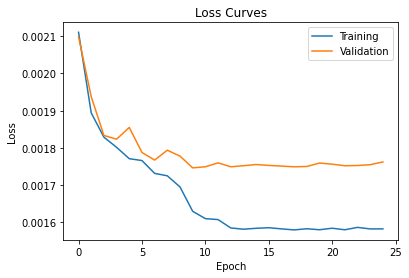

In [11]:
model = RegressionNet()
optimizer = optim.Adam([
                            {'params': model.first.parameters(), 'lr': 3e-6},
                            {'params': model.second.parameters(), 'lr': 3e-6},
                            {'params': model.third.parameters(), 'lr': 3e-6},
                            {'params': model.fourth.parameters(), 'lr': 3e-6},
                            {'params': model.fifth.parameters()},
                            {'params': model.sixth.parameters()},
                            {'params': model.seventh.parameters()},
                            {'params': model.eighth.parameters()},
                            {'params': model.transpose1.parameters()},
                            {'params': model.transpose2.parameters()},
                            {'params': model.transpose3.parameters()}
                       ], lr=1e-3)
scheduler = ReduceLROnPlateau(
    optimizer, 'min', patience=1,
    min_lr=1e-10, verbose=True
)
loss_func = nn.SmoothL1Loss()
train_losses, val_losses, best = train(model, optimizer, scheduler, loss_func, epochs=25)

plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [12]:
print(f"Test Loss: {check_loss('test', best['model'], loss_func, None):.6f}")

Test Loss: 0.001829


Testing on Test Images...


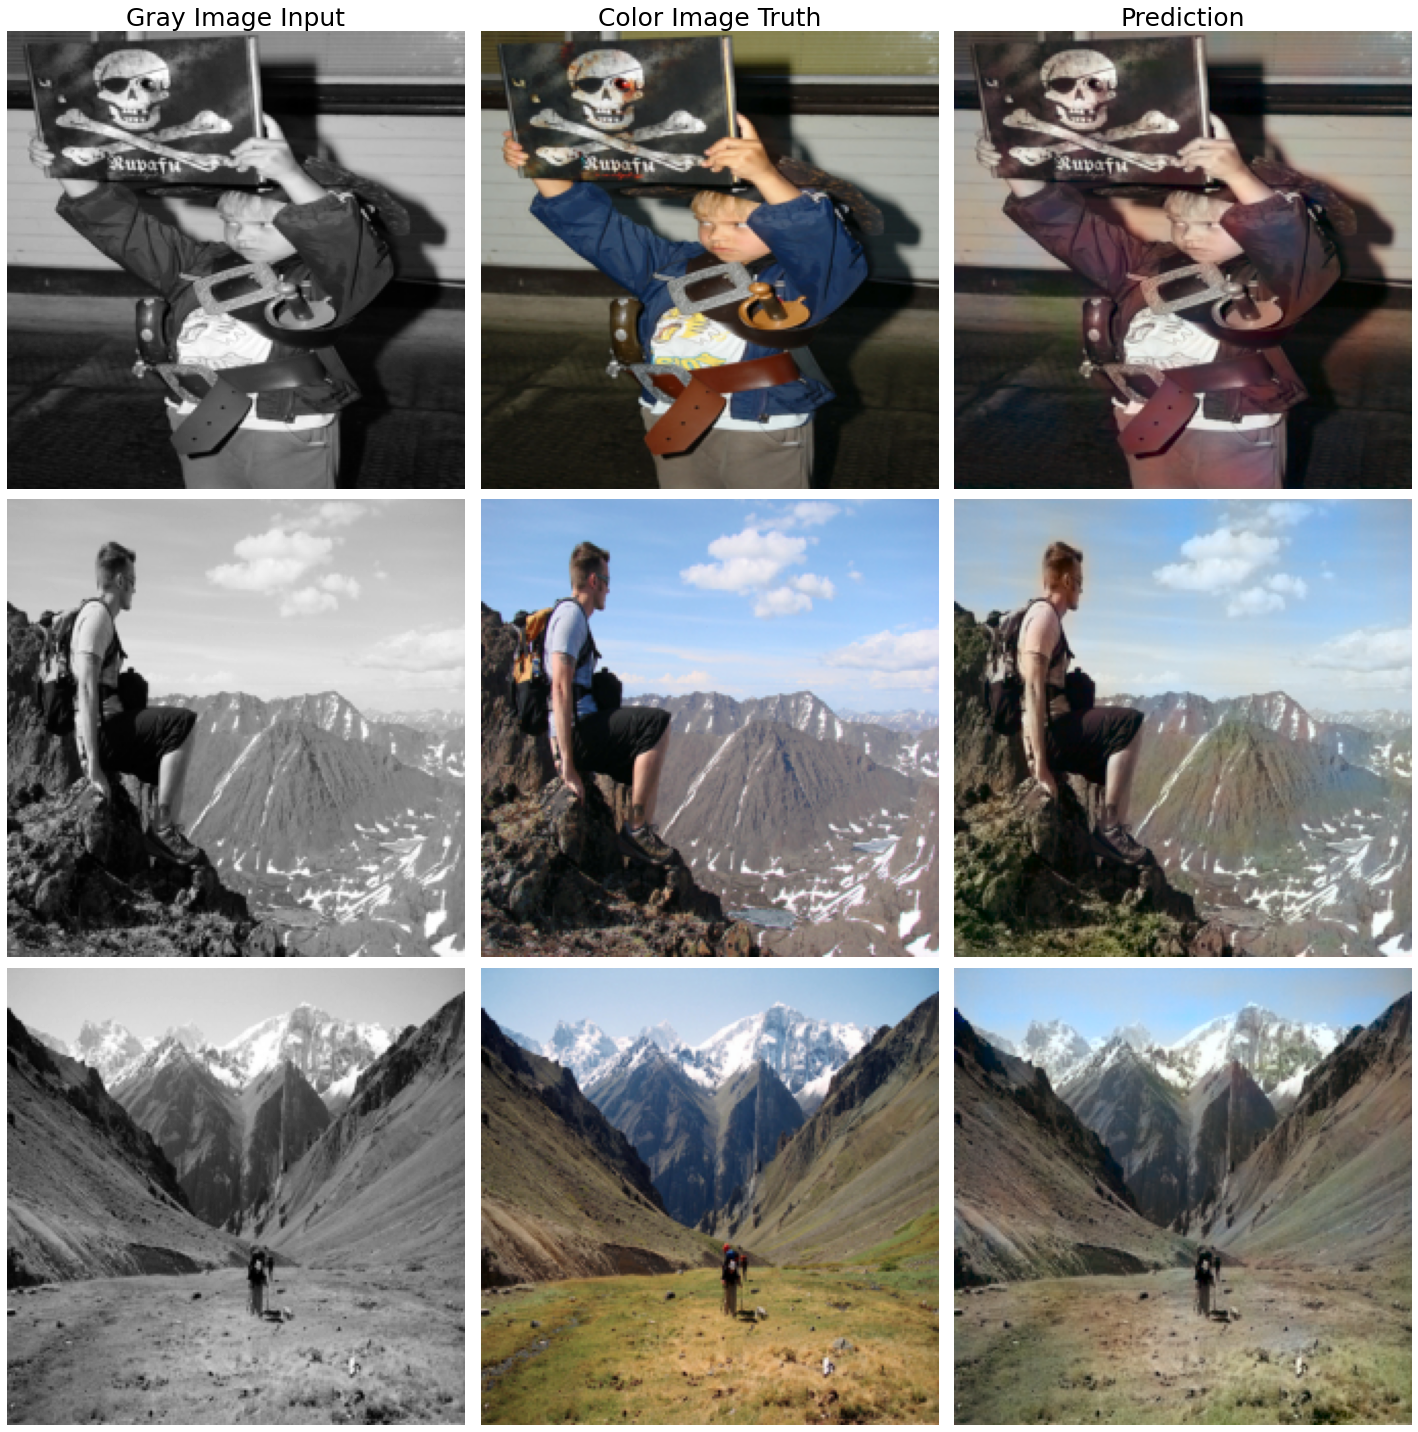

In [23]:
test_on_random_images('test', best['model'])

In [14]:
torch.save(model.state_dict(), 'out_model.pth')
np.savez('out_losses', train=train_losses, val=val_losses)

# Older Versions of Model

In [15]:
class RegressionNetUpsampleSigmoid(nn.Module):
    def __init__(self):
        super(RegressionNetUpsampleSigmoid, self).__init__()
        pretrained_vgg16 = models.vgg16_bn(pretrained=True, progress=True)
        
        self.first = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6)])
        self.second = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6,13)])
        self.third = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(13,23)])
        self.fourth = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(23,33)])
                
        self.fifth = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1), nn.BatchNorm2d(256), nn.ReLU())
        self.sixth = nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.seventh = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.eighth = nn.Sequential(nn.Conv2d(64, 2, kernel_size=3, padding=1), nn.Sigmoid())

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
    def forward(self, x):
        out1 = self.first(x)
        out2 = self.second(out1)
        out3 = self.third(out2)
        out4 = self.fourth(out3)
                
        out5 = self.fifth(out4)
        out6 = self.sixth(self.upsample(out5) + out3)
        out7 = self.seventh(self.upsample(out6) + out2)
        out8 = self.eighth(self.upsample(out7) + out1)
    
        return out8

In [16]:
class RegressionNetUpsampleReLU(nn.Module):
    def __init__(self):
        super(RegressionNetUpsampleReLU, self).__init__()
        pretrained_vgg16 = models.vgg16_bn(pretrained=True, progress=True)
        
        self.first = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6)])
        self.second = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(6,13)])
        self.third = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(13,23)])
        self.fourth = nn.Sequential(*[pretrained_vgg16.features[i] for i in range(23,33)])
                
        self.fifth = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1), nn.BatchNorm2d(256), nn.ReLU())
        self.sixth = nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.seventh = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.eighth = nn.Sequential(nn.Conv2d(64, 2, kernel_size=3, padding=1), nn.ReLU())

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
    def forward(self, x):
        out1 = self.first(x)
        out2 = self.second(out1)
        out3 = self.third(out2)
        out4 = self.fourth(out3)
                
        out5 = self.fifth(out4)
        out6 = self.sixth(self.upsample(out5) + out3)
        out7 = self.seventh(self.upsample(out6) + out2)
        out8 = self.eighth(self.upsample(out7) + out1)
    
        return out8

## Ablation Study

In [17]:
relu_last_model = RegressionNetUpsampleReLU()
relu_last_model.load_state_dict(torch.load('model1.pth'))
relu_last_model.to(device)
print(f"ReLU Last Layer Test Loss: {check_loss('test', relu_last_model, loss_func, None):.6f}")

sigmoid_upsample_model = RegressionNetUpsampleSigmoid()
sigmoid_upsample_model.load_state_dict(torch.load('model2-sigmoid.pth'))
sigmoid_upsample_model.to(device)
print(f"Upsampling Test Loss: {check_loss('test', sigmoid_upsample_model, loss_func, None):.6f}")

half_data_model = RegressionNet()
half_data_model.load_state_dict(torch.load('model2-transpose.pth'))
half_data_model.to(device)
print(f"Half Data Model Test Loss: {check_loss('test', half_data_model, loss_func, None):.6f}")

regularization_model = RegressionNet()
regularization_model.load_state_dict(torch.load('model2-transpose-weightdecay1e3.pth'))
regularization_model.to(device)
print(f"Regularization Test Loss: {check_loss('test', regularization_model, loss_func, None):.6f}")

samelr_model = RegressionNet()
samelr_model.load_state_dict(torch.load('model2-transpose-samelr.pth'))
samelr_model.to(device)
print(f"Universal Learning Rate Test Loss: {check_loss('test', samelr_model, loss_func, None):.6f}")

best_model = RegressionNet()
best_model.load_state_dict(torch.load('model2-transpose-fulldata_ACTUAL.pth'))
best_model.to(device)
print(f"Best Model Test Loss: {check_loss('test', best_model, loss_func, None):.6f}")

ReLU Last Layer Test Loss: 0.003386
Upsampling Test Loss: 0.001934
Half Data Model Test Loss: 0.001930
Regularization Test Loss: 0.001890
Universal Learning Rate Test Loss: 0.001876
Best Model Test Loss: 0.001849


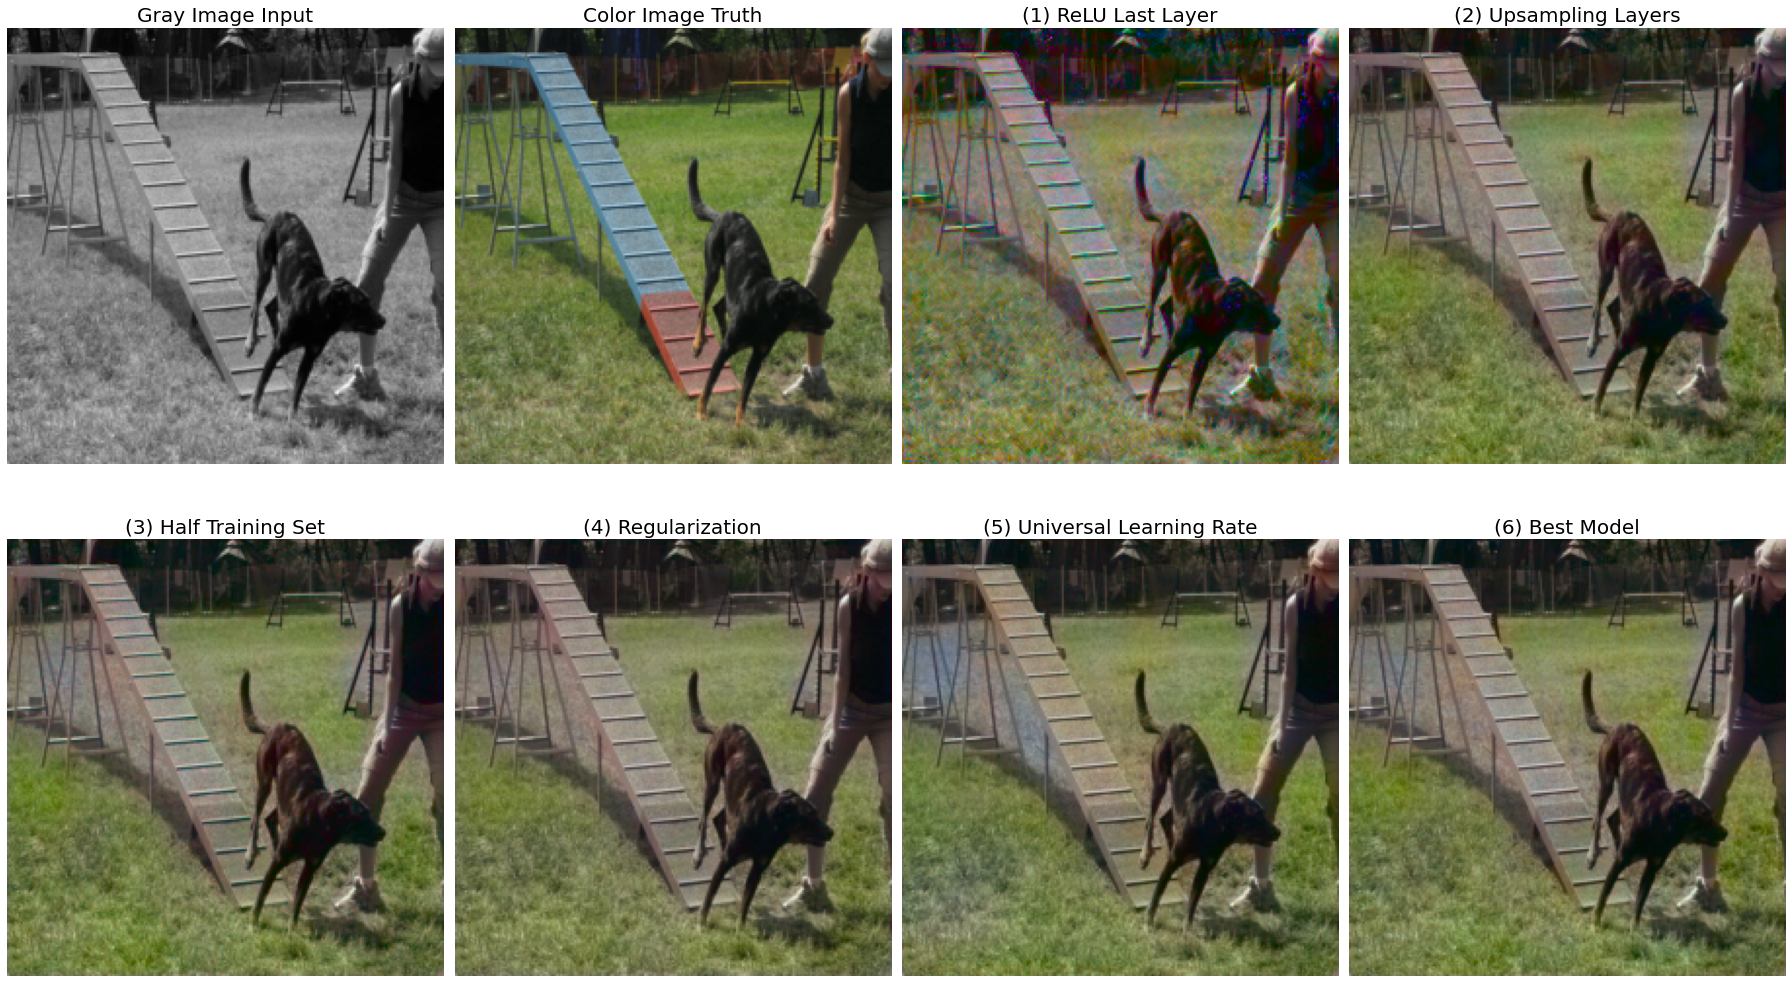

In [18]:
indices = (0, test_indices[1] - test_indices[0])
original_dataset = flick8k_test

subset_indices = np.random.randint(*indices, 1)
subset = Subset(original_dataset, subset_indices)
loader_subset = DataLoader(subset, batch_size=1, shuffle=False)

fig, axs = plt.subplots(2, 4, figsize=(25,15))

models = [relu_last_model, sigmoid_upsample_model, half_data_model, regularization_model, samelr_model, best_model]
for i in range(len(models)):
    models[i] = models[i].to(device='cpu')
    models[i].eval()

with torch.no_grad():
    for i, (normalized_input, uv_channel, l_channel) in enumerate(loader_subset):
        reformed_image = torch.stack((l_channel[0], uv_channel[0][0], uv_channel[0][1]), dim=0)
        reformed_pil_image = T.functional.to_pil_image(reformed_image)
        truth_luv = np.array(reformed_pil_image)
        truth_rgb = cv2.cvtColor(truth_luv, cv2.COLOR_Luv2RGB)

        axs[0, 0].imshow(truth_luv[:, :, 0], cmap='gray')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(truth_rgb)
        axs[0, 1].axis('off')

        for j, model in enumerate(models):
            pred = model(normalized_input)
            reformed_pred = torch.stack((l_channel[0], pred[0][0], pred[0][1]), dim=0)
            reformed_pil_pred = T.functional.to_pil_image(reformed_pred)
            pred_luv = np.array(reformed_pil_pred)
            pred_rgb = cv2.cvtColor(pred_luv, cv2.COLOR_Luv2RGB)
            
            if j < 2:
                axs[0, 2+j].imshow(pred_rgb)
                axs[0, 2+j].axis('off')
            else:
                axs[1, j-2].imshow(pred_rgb)
                axs[1, j-2].axis('off')


axs[0, 0].set_title('Gray Image Input', fontsize=20)
axs[0, 1].set_title('Color Image Truth', fontsize=20)
axs[0, 2].set_title('(1) ReLU Last Layer', fontsize=20)
axs[0, 3].set_title('(2) Upsampling Layers', fontsize=20)
axs[1, 0].set_title('(3) Half Training Set', fontsize=20)
axs[1, 1].set_title('(4) Regularization', fontsize=20)
axs[1, 2].set_title('(5) Universal Learning Rate', fontsize=20)
axs[1, 3].set_title('(6) Best Model', fontsize=20)

plt.tight_layout()
plt.savefig('ablation.jpg')
plt.show()